In [3]:
import os, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import label_binarize
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

In [4]:
print("GPUs:", tf.config.list_physical_devices('GPU'))
seed = 42

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Transfer Learning freeze all for classification 6 classes

In [6]:
# Assign params
label_map_cs = {
    'clean': 0,
    'eth': 1,
    'url': 2,
    'ps': 3,
    'html': 4,
    'js': 5,
}

def get_paths_and_labels_class_task(target_dir, label_map):
    classes = ['clean', 'stego']
    paths, labels = [], []
    for cls in classes:
        folder = os.path.join(target_dir, cls)
        for file in os.listdir(folder):
            full_path = os.path.join(folder, file)
            paths.append(full_path)
            if cls == 'clean':
                labels.append(label_map['clean'])
            else:
                found = False
                for key in label_map:
                    if key != 'clean' and key in file:
                        labels.append(label_map[key])
                        found = True
                        break
                if not found:
                    raise ValueError(f"File not found: {file}")
    return paths, np.array(labels)

In [7]:
# create datasets
train_paths_cs, train_labels_cs = get_paths_and_labels_class_task(train_dir, label_map_cs)
val_paths_cs,   val_labels_cs   = get_paths_and_labels_class_task(val_dir, label_map_cs)
test_paths_cs, test_labels_cs = get_paths_and_labels_class_task(test_dir, label_map_cs)
base64_paths_cs, base64_labels_cs = get_paths_and_labels_class_task(base64_enc, label_map_cs)
zip_paths_cs, zip_labels_cs = get_paths_and_labels_class_task(zip_enc, label_map_cs)

train_ds_cs = (tf.data.Dataset.from_tensor_slices((train_paths_cs, train_labels_cs))
    .shuffle(len(train_paths_cs))
    .map(lambda p,l: preprocess(p,l,True), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

val_ds_cs = (tf.data.Dataset.from_tensor_slices((val_paths_cs, val_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

test_ds_cs = (tf.data.Dataset.from_tensor_slices((test_paths_cs, test_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

base64_ds_cs = (tf.data.Dataset.from_tensor_slices((base64_paths_cs, base64_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

zip_ds_cs = (tf.data.Dataset.from_tensor_slices((zip_paths_cs, zip_labels_cs))
    .map(lambda p,l: preprocess(p,l,False), num_parallel_calls=AUTOTUNE)
    .batch(batch_size).prefetch(AUTOTUNE)
)

# Transfer Learning Freeze layer ke 0-5

In [6]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_5
for layer in model_bin.layers[:8]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759486902.357586      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 17,286 (67.52 KB)

 Non-trainable params: 287,296 (1.10 MB)

In [7]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_all.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [8]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer
)
end = time.time()

Epoch 1/60


I0000 00:00:1759486988.392366      71 service.cc:148] XLA service 0x7ebdc4009500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759486988.393301      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  4/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.2975 - loss: 3.0947

I0000 00:00:1759486991.792671      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3127 - loss: 2.1769
Epoch 1: val_loss improved from inf to 1.36349, saving model to mini_vgg_tl_031025_freeze_all.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 252ms/step - accuracy: 0.3127 - loss: 2.1761 - val_accuracy: 0.3400 - val_loss: 1.3635 - learning_rate: 1.0000e-05
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.4003 - loss: 1.3127
Epoch 2: val_loss improved from 1.36349 to 1.13327, saving model to mini_vgg_tl_031025_freeze_all.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 181ms/step - accuracy: 0.4004 - loss: 1.3126 - val_accuracy: 0.6858 - val_loss: 1.1333 - learning_rate: 1.0000e-05
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6814 - loss: 1.1147
Epoch 3: val_loss improved from 1.13327 to 1.05021, saving model to mini_vgg_tl_031025_freeze_all.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 184ms/step - accuracy: 0.6813 - loss: 1.1146 - val_accuracy: 0.6016 - val_loss: 1.0502 - learning_rate: 1.000

NameError: name 'start_time' is not defined

In [9]:
duration = time.time() - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Training completed in 5817.94 seconds (96.97 minutes)


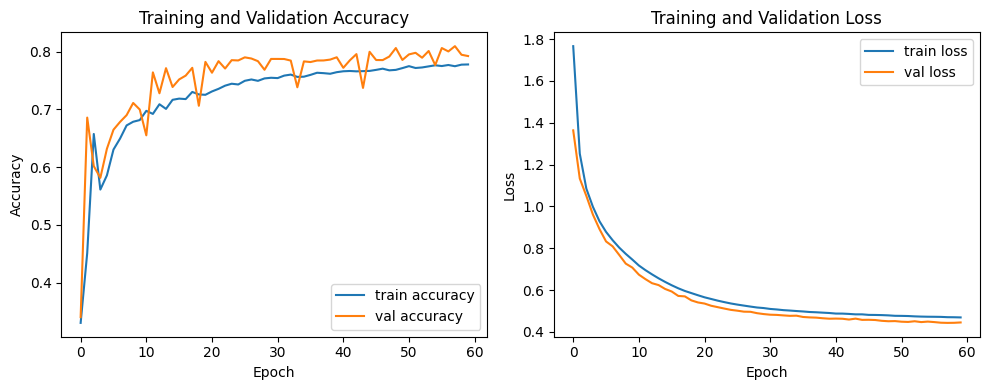

In [19]:
# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0-4

In [17]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:7]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 164,870 (644.02 KB)

 Non-trainable params: 139,712 (545.75 KB)

In [18]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-4.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1696 - loss: 4.7250
Epoch 1: val_loss improved from inf to 1.43270, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 185ms/step - accuracy: 0.1697 - loss: 4.7221 - val_accuracy: 0.2550 - val_loss: 1.4327 - learning_rate: 1.0000e-05
Epoch 2/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4029 - loss: 1.3747
Epoch 2: val_loss improved from 1.43270 to 1.11159, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 92s 185ms/step - accuracy: 0.4032 - loss: 1.3745 - val_accuracy: 0.6360 - val_loss: 1.1116 - learning_rate: 1.0000e-05
Epoch 3/60
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5341 - loss: 1.1251
Epoch 3: val_loss improved from 1.11159 to 0.97192, saving model to mini_vgg_tl_031025_freeze_0-4.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - accuracy: 0.5341 - loss: 1.1250 - val_accuracy: 0.5700 - val_loss: 0.9719 - learning_r

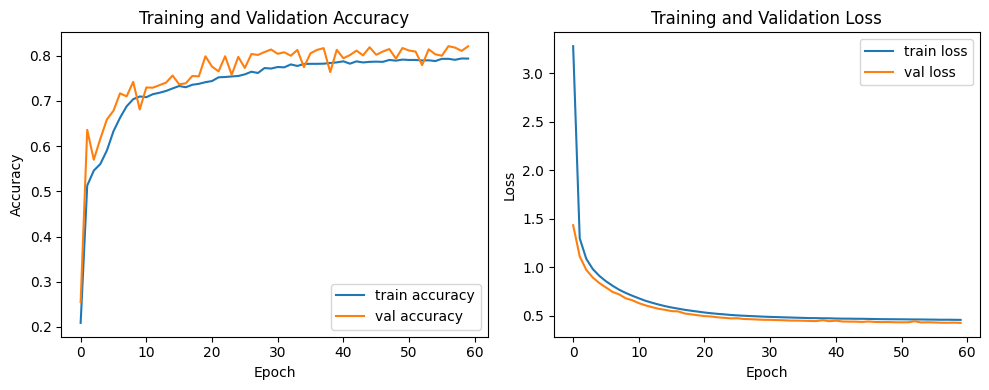

In [20]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer
)
end = time.time()

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Training completed in 5511.42 seconds (91.86 minutes)


# Transfer Learning Freeze layer ke 0-3

In [31]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:6]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 238,726 (932.52 KB)

 Non-trainable params: 65,856 (257.25 KB)

In [32]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_8 → Trainable: True
1: conv2d_48 → Trainable: False
2: conv2d_49 → Trainable: False
3: max_pooling2d_24 → Trainable: False
4: conv2d_50 → Trainable: False
5: conv2d_51 → Trainable: False
6: max_pooling2d_25 → Trainable: False
7: conv2d_52 → Trainable: True
8: conv2d_53 → Trainable: True
9: max_pooling2d_26 → Trainable: True
10: global_average_pooling2d_8 → Trainable: True
11: dense_34 → Trainable: True
12: dense_35 → Trainable: True


In [34]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-3.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.23800, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 98s - 195ms/step - accuracy: 0.2929 - loss: 1.6512 - val_accuracy: 0.4408 - val_loss: 1.2380 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.23800 to 0.98543, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 102s - 204ms/step - accuracy: 0.5132 - loss: 1.1128 - val_accuracy: 0.5181 - val_loss: 0.9854 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.98543 to 0.90190, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 90s - 180ms/step - accuracy: 0.5418 - loss: 0.9661 - val_accuracy: 0.5197 - val_loss: 0.9019 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.90190 to 0.83861, saving model to mini_vgg_tl_031025_freeze_0-3.keras
500/500 - 90s - 180ms/step - accuracy: 0.5700 - loss: 0.8923 - val_accuracy: 0.5692 - val_loss: 0.8386 - learning_rate: 1.0000e-05
Epoch 5/60

Epo

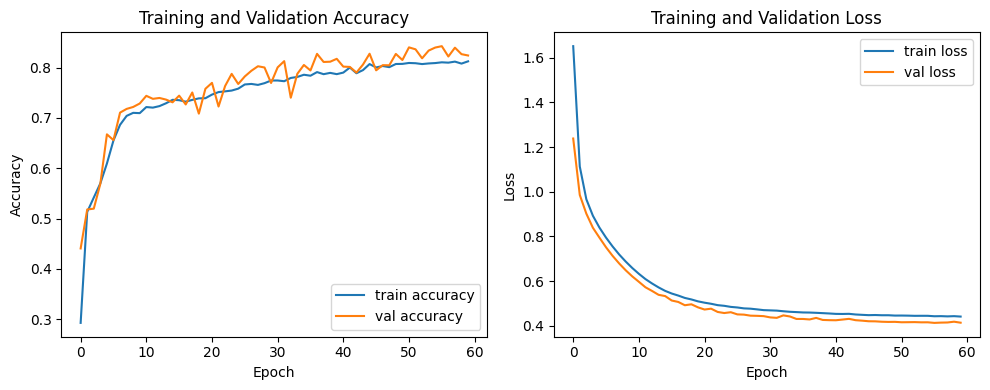

In [35]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

Training completed in 5705.95 seconds (95.10 minutes)


# Transfer Learning Freeze layer ke 0-2

In [36]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:4]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 275,654 (1.05 MB)

 Non-trainable params: 28,928 (113.00 KB)

In [37]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_9 → Trainable: True
1: conv2d_54 → Trainable: False
2: conv2d_55 → Trainable: False
3: max_pooling2d_27 → Trainable: False
4: conv2d_56 → Trainable: False
5: conv2d_57 → Trainable: True
6: max_pooling2d_28 → Trainable: True
7: conv2d_58 → Trainable: True
8: conv2d_59 → Trainable: True
9: max_pooling2d_29 → Trainable: True
10: global_average_pooling2d_9 → Trainable: True
11: dense_38 → Trainable: True
12: dense_39 → Trainable: True


In [38]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-2.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.36623, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 99s - 197ms/step - accuracy: 0.2791 - loss: 2.8329 - val_accuracy: 0.4232 - val_loss: 1.3662 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.36623 to 1.00715, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 92s - 184ms/step - accuracy: 0.4945 - loss: 1.1571 - val_accuracy: 0.5520 - val_loss: 1.0072 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 1.00715 to 0.87712, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 92s - 183ms/step - accuracy: 0.5464 - loss: 0.9495 - val_accuracy: 0.5681 - val_loss: 0.8771 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.87712 to 0.80079, saving model to mini_vgg_tl_031025_freeze_0-2.keras
500/500 - 92s - 184ms/step - accuracy: 0.5903 - loss: 0.8543 - val_accuracy: 0.5847 - val_loss: 0.8008 - learning_rate: 1.0000e-05
Epoch 5/60

Epoc

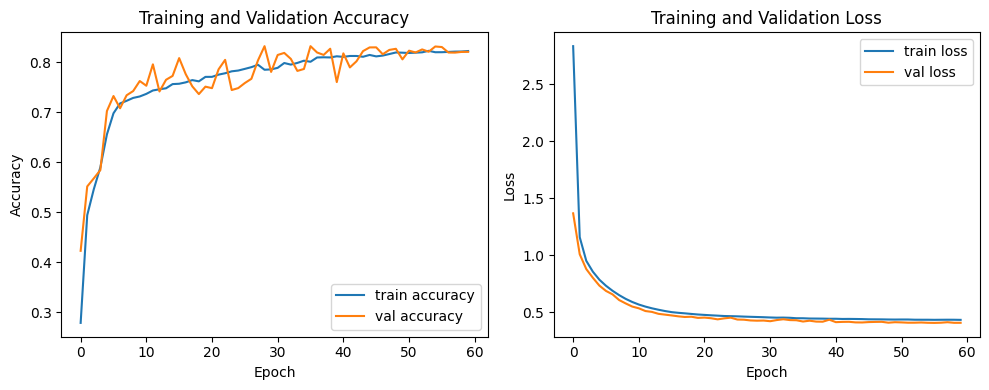

In [40]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0-1

In [6]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:3]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759541148.202601      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 294,150 (1.12 MB)

 Non-trainable params: 10,432 (40.75 KB)

In [7]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: False
3: max_pooling2d → Trainable: False
4: conv2d_2 → Trainable: True
5: conv2d_3 → Trainable: True
6: max_pooling2d_1 → Trainable: True
7: conv2d_4 → Trainable: True
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [8]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0-1.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759541233.472060      72 service.cc:148] XLA service 0x7ef5b400dbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759541233.472865      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759541240.042097      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.25312, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 123s - 246ms/step - accuracy: 0.2620 - loss: 3.0413 - val_accuracy: 0.4275 - val_loss: 1.2531 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.25312 to 0.98623, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 96s - 191ms/step - accuracy: 0.5050 - loss: 1.1312 - val_accuracy: 0.5361 - val_loss: 0.9862 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.98623 to 0.87374, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 95s - 190ms/step - accuracy: 0.5379 - loss: 0.9551 - val_accuracy: 0.5527 - val_loss: 0.8737 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.87374 to 0.80486, saving model to mini_vgg_tl_031025_freeze_0-1.keras
500/500 - 95s - 190ms/step - accuracy: 0.5660 - loss: 0.8673 - val_accuracy: 0.6146 - val_loss: 0.8049 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_l

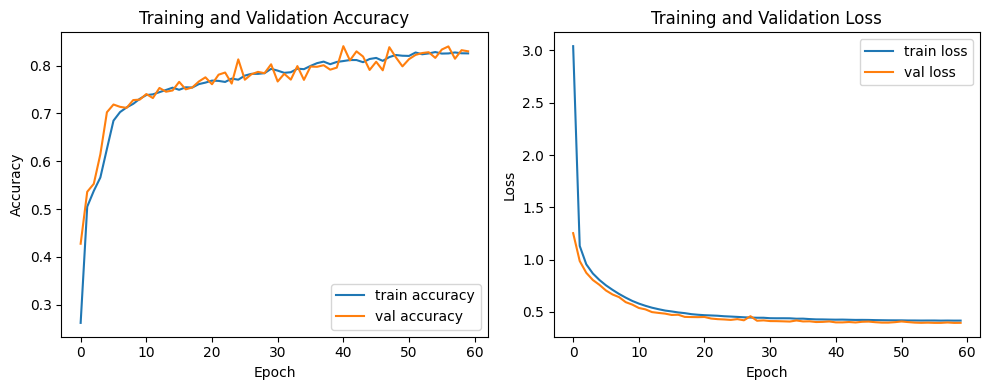

In [9]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning Freeze layer ke 0

In [8]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Bekukan layer Conv2D sampai conv2d_4
for layer in model_bin.layers[:1]:
    layer.trainable = False

# 4. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 5. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 6. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 7. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


I0000 00:00:1759547763.262245      36 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 303,398 (1.16 MB)

 Non-trainable params: 1,184 (4.62 KB)

In [9]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer → Trainable: True
1: conv2d → Trainable: False
2: conv2d_1 → Trainable: True
3: max_pooling2d → Trainable: True
4: conv2d_2 → Trainable: True
5: conv2d_3 → Trainable: True
6: max_pooling2d_1 → Trainable: True
7: conv2d_4 → Trainable: True
8: conv2d_5 → Trainable: True
9: max_pooling2d_2 → Trainable: True
10: global_average_pooling2d → Trainable: True
11: dense_2 → Trainable: True
12: dense_3 → Trainable: True


In [10]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_freeze_0.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60


I0000 00:00:1759547819.413143      72 service.cc:148] XLA service 0x7fb8b400e160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759547819.413848      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759547827.763784      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 1.61106, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 132s - 263ms/step - accuracy: 0.2994 - loss: 2.0569 - val_accuracy: 0.3058 - val_loss: 1.6111 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.61106 to 0.96935, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 92s - 184ms/step - accuracy: 0.4361 - loss: 1.2991 - val_accuracy: 0.5511 - val_loss: 0.9694 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.96935 to 0.83068, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 92s - 184ms/step - accuracy: 0.5729 - loss: 0.9043 - val_accuracy: 0.6784 - val_loss: 0.8307 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.83068 to 0.72238, saving model to mini_vgg_tl_031025_freeze_0.keras
500/500 - 92s - 183ms/step - accuracy: 0.6619 - loss: 0.7923 - val_accuracy: 0.7230 - val_loss: 0.7224 - learning_rate: 1.0000e-05
Epoch 5/60

Epoch 5: val_loss impr

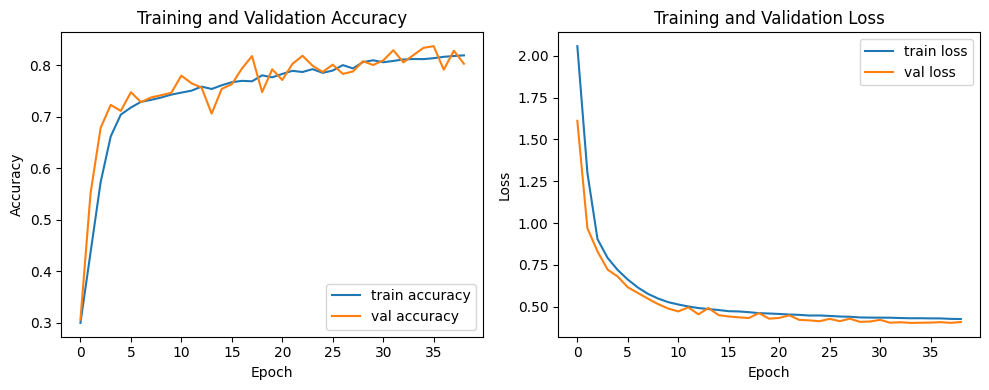

In [11]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Transfer Learning unfreeze all

In [12]:
# 1. Load model hasil training binary classification
model_bin = build_mini_vgg(input_shape=(256,256,4))
model_bin.load_weights('/kaggle/input/minivgg256/tensorflow2/default/1/mini_vgg_256_hp.keras')

# 2. Panggil dummy input agar .input dan .output terbentuk
dummy_input = tf.zeros((1, 256, 256, 4))
_ = model_bin(dummy_input)

# 3. Ambil input & output feature extractor secara aman
base_input = model_bin.layers[0].input            # input layer
base_output = model_bin.layers[-3].output         # output GlobalAveragePooling2D

# 4. Tambahkan head baru untuk klasifikasi payload
dense1 = Dense(128, activation='relu')(base_output)
final_output = Dense(6, activation='softmax')(dense1)

# 5. Bangun model baru
model_cs_transfer = Model(inputs=base_input, outputs=final_output)

# 6. Kompilasi model
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cs_transfer.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,582 (1.16 MB)

 Trainable params: 304,582 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
for i, layer in enumerate(model_cs_transfer.layers):
    print(f"{i}: {layer.name} → Trainable: {layer.trainable}")

0: input_layer_1 → Trainable: True
1: conv2d_6 → Trainable: True
2: conv2d_7 → Trainable: True
3: max_pooling2d_3 → Trainable: True
4: conv2d_8 → Trainable: True
5: conv2d_9 → Trainable: True
6: max_pooling2d_4 → Trainable: True
7: conv2d_10 → Trainable: True
8: conv2d_11 → Trainable: True
9: max_pooling2d_5 → Trainable: True
10: global_average_pooling2d_1 → Trainable: True
11: dense_6 → Trainable: True
12: dense_7 → Trainable: True


In [14]:
# Kompilasi
model_cs_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cbs_transfer = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('mini_vgg_tl_031025_unfreeze_all.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

Epoch 1/60

Epoch 1: val_loss improved from inf to 1.15468, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 99s - 197ms/step - accuracy: 0.3945 - loss: 1.5970 - val_accuracy: 0.4963 - val_loss: 1.1547 - learning_rate: 1.0000e-05
Epoch 2/60

Epoch 2: val_loss improved from 1.15468 to 0.86518, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 93s - 186ms/step - accuracy: 0.5433 - loss: 0.9823 - val_accuracy: 0.6219 - val_loss: 0.8652 - learning_rate: 1.0000e-05
Epoch 3/60

Epoch 3: val_loss improved from 0.86518 to 0.77393, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 95s - 190ms/step - accuracy: 0.6036 - loss: 0.8422 - val_accuracy: 0.6478 - val_loss: 0.7739 - learning_rate: 1.0000e-05
Epoch 4/60

Epoch 4: val_loss improved from 0.77393 to 0.70947, saving model to mini_vgg_tl_031025_unfreeze_all.keras
500/500 - 96s - 191ms/step - accuracy: 0.6728 - loss: 0.7672 - val_accuracy: 0.7266 - val_loss: 0.7095 - learning_rate: 1.0000e-05
Epoch 5/

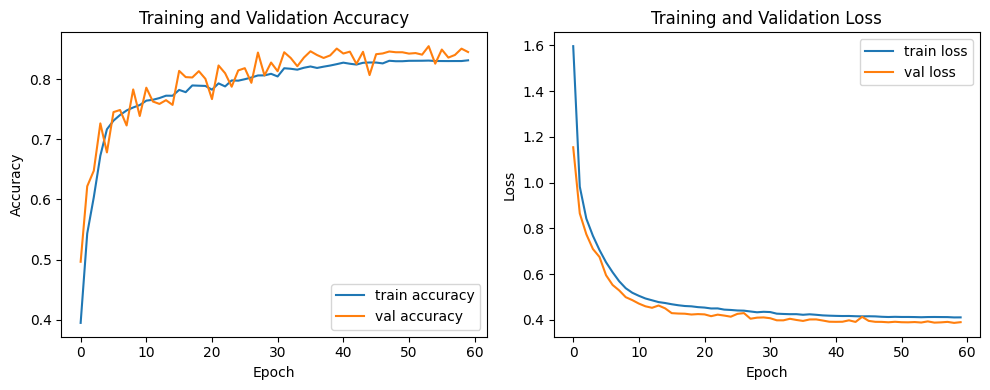

In [15]:
start = time.time()
history_transfer = model_cs_transfer.fit(
    train_ds_cs,               
    validation_data=val_ds_cs,
    epochs=60,
    batch_size=32,
    callbacks=cbs_transfer,
    verbose=2
)
end = time.time()
duration = end - start
print(f"Training completed in {duration:.2f} seconds ({duration/60:.2f} minutes)")

# Plot Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='train accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='train loss')
plt.plot(history_transfer.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()